# Ch. 6

In [25]:
# minimal imports
import pandas as pd
import numpy as np
from plotnine import *
import plotnine.options as p9options

# needed for Fig. 6.15
import seaborn as sns

# for graphical enhancement
from mizani.labels import label_date, label_dollar, label_percent, label_comma
from mizani.palettes import brewer_pal
from pysocviz.p9extra import wrap_format
from pysocviz.properties import dcolors

p9options.figure_size = (5.4, 4.8)
theme_set(theme_minimal())

In [26]:
# Needed by smoothing and modeling and regression analysis
# You need to install scikit-misc package
from statsmodels.formula.api import ols, glm, logit, phreg
import statsmodels.api as sm
import patsy  # needed at Fig. 6.11, but if you import`cplot` from pysocviz, it's not needed.

# Some utilities functions requreid in the specific situations
from pysocviz.utils import prefix_strip, brackets_replace, cplot, coefplot, tidy_ols

# dataset packages
from gapminder import gapminder
from pysocviz.loader import load_dataset

gss_sm = load_dataset('gss_sm')
gss_lon = load_dataset('gss_lon')
organdata = load_dataset('organdata')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
lung = sm.datasets.get_rdataset("cancer", "survival").data

## Fig. 6.1


NOTE: Currently (v0.8) `plotnine.geom.geom_quantile` doesn't support addtive quantile regression model like RQSS. So I instedly use linear quantile regression algorithm.

In [27]:
p = ggplot(gapminder, aes(x='np.log(gdpPercap)', y='lifeExp'))

(
  p + geom_point(alpha=0.1) + geom_smooth(
    color="tomato", fill="tomato", method='rlm'
  ) + geom_smooth(color="steelblue", fill="steelblue", method="lm")
).draw();

(
  p + geom_point(alpha=0.1) + geom_smooth(
    color="tomato", method="lm", size=1.2, formula='y ~ bs(x, 3)',
    se=False
  )
).draw();
(
  p + geom_point(alpha=0.1) + geom_quantile(
    color="tomato", size=1.2, quantiles=[0.20, 0.5, 0.85])
).draw();

/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/plotnine/stats/smoothers.py:164: PlotnineWarning: Confidence intervals are not yet implemented for RLM smoothing.
/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.


## Fig. 6.2

NOTE: As I mentioned about Fig. 5.26, I think the original code is unreliable. I suggest to use a named vector with `ggplot2::scale_color_manual`, while to use a dictionary with `plotnine.sacle_color_manual`

In [28]:
models = ['Cubic Spline', 'LOESS', 'OLS']
model_colors = brewer_pal('qual', 'Set1')(len(models))
model_colors = dict(zip(models, model_colors))

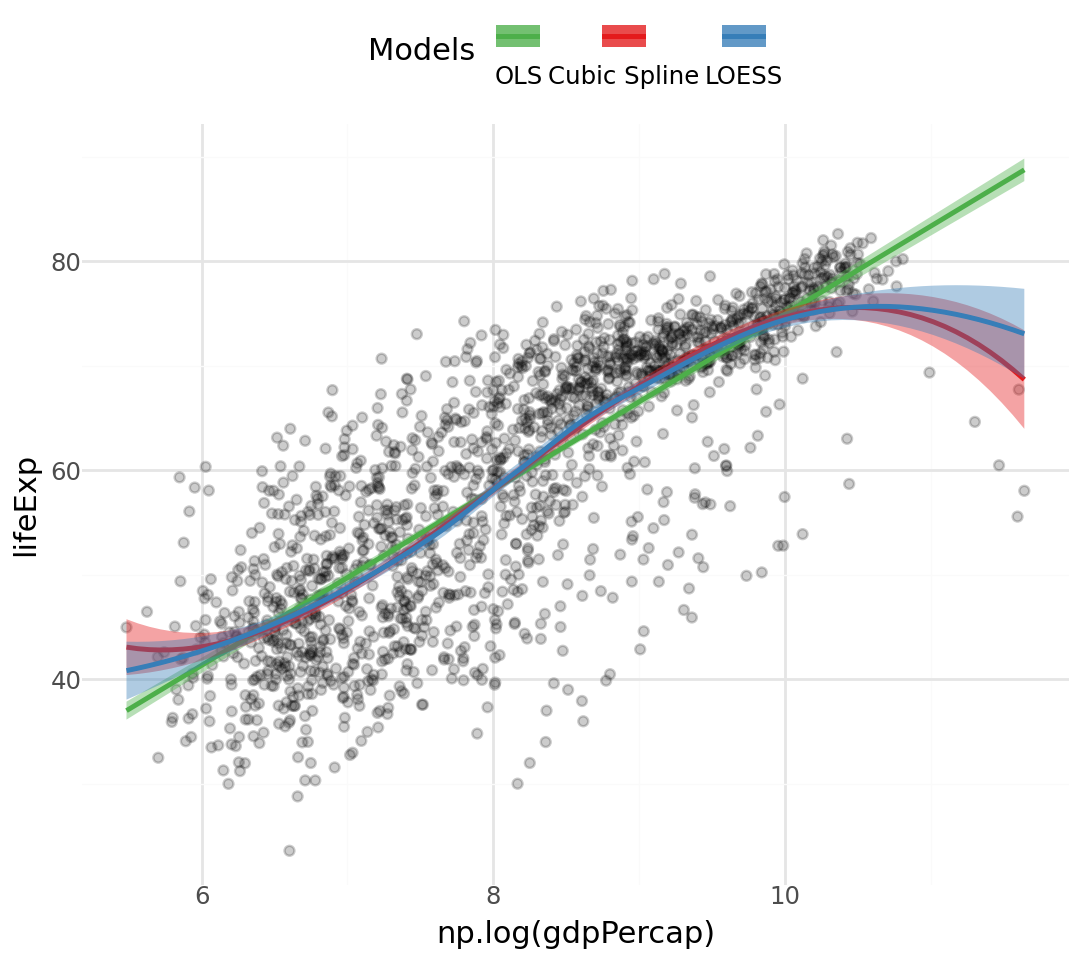

In [29]:
p0 = ggplot(gapminder, aes(x='np.log(gdpPercap)', y='lifeExp'))
p1 = p0 + geom_point(alpha=0.2) + geom_smooth(
  aes(color='"OLS"', fill='"OLS"'),
  method='lm',
) + geom_smooth(
  aes(color='"Cubic Spline"', fill='"Cubic Spline"'),
  method='lm', formula='y ~ bs(x, df = 3)',
) + geom_smooth(aes(color='"LOESS"', fill='"LOESS"'), method='loess')

p1 + scale_color_manual(name="Models", values=model_colors
) + scale_fill_manual(name="Models", values=model_colors
) + theme(legend_position="top")

## Fig. 6.4

In [30]:
# regression and output tidying

out = ols('lifeExp ~ gdpPercap + pop + continent', data=gapminder).fit()
min_gdp, max_gdp = gapminder['gdpPercap'].min(), gapminder['gdpPercap'].max()
med_pop = gapminder['pop'].median()
pred_df = pd.DataFrame(
  np.array(
    [(gdp, con) for gdp in np.linspace(
      min_gdp, max_gdp, 100
    ) for con in gapminder['continent'].unique()]
  ),
  columns=['gdpPercap', 'continent']
).assign(pop=med_pop, gdpPercap=lambda d: d['gdpPercap'].astype(float))
pred_out = out.get_prediction(pred_df).summary_frame(alpha=.05)  # .predict() cannot display the c.i.
pred_out = pred_out.rename(
  columns={'mean': 'fit', 'obs_ci_lower': 'lwr', 'obs_ci_upper': 'upr'}
)[['fit', 'lwr', 'upr']]
pred_out.head()
pred_df = pd.concat((pred_df, pred_out), axis=1)

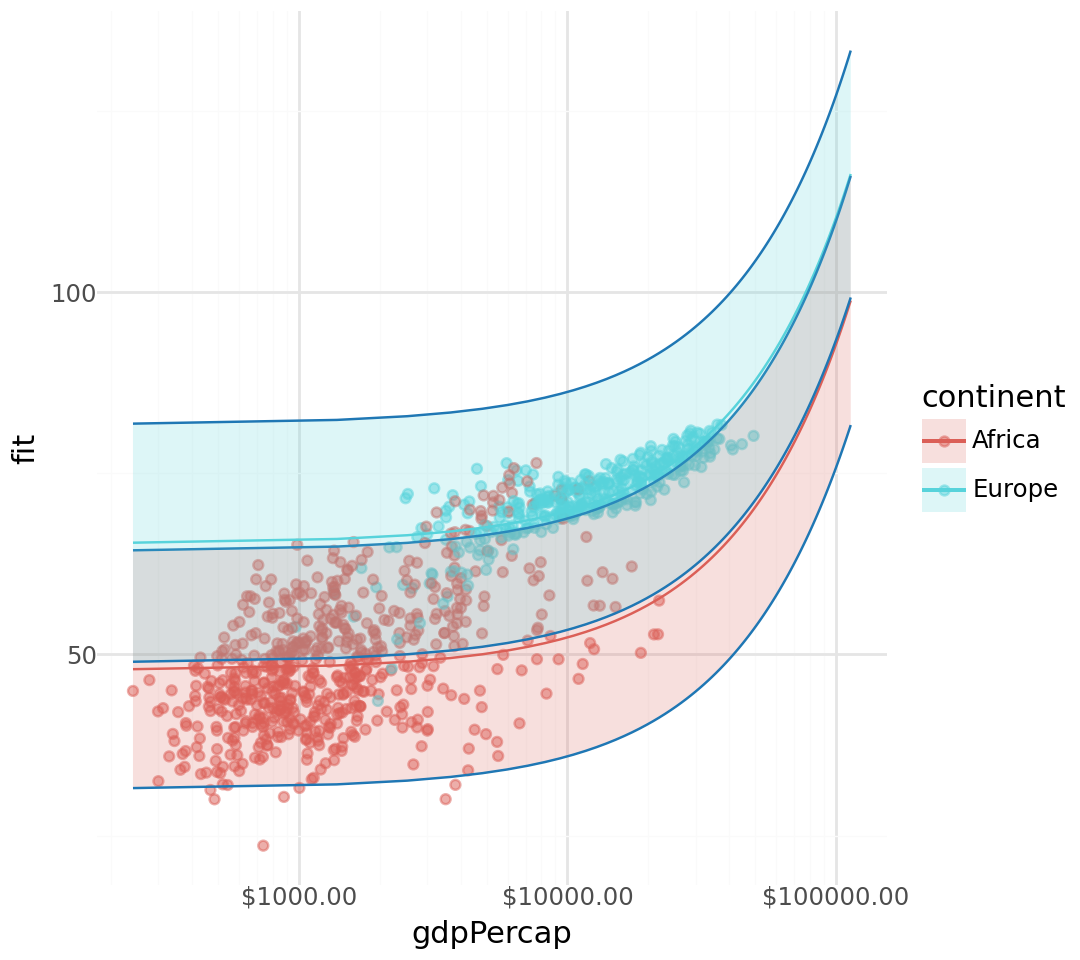

In [31]:
p = ggplot(
  pred_df.loc[lambda d: d['continent'].isin(['Europe', 'Africa'])],
  aes(x='gdpPercap', y='fit', ymin='lwr', ymax='upr', color='continent',
      fill='continent', group='continent')
)

p + geom_point(
  aes(x='gdpPercap', y='lifeExp', color='continent'),
  data=gapminder.loc[lambda d: d['continent'].isin(['Europe', 'Africa'])],
  alpha = 0.5, inherit_aes = False
) + geom_line() + geom_ribbon(
  alpha=0.2, color=None
) + scale_x_log10(labels=label_dollar())

## Fig. 6.5

NOTE: Python has no packages like **broom** in R. So I defined manually an alike function, `tidy_ols()`. You can also import this function by `from pysocviz.utils import tidy_ols`. the actural code is like this:


```python
def tidy_ols(ols_result, conf_int=False):
    tidy = pd.DataFrame(
        {
            'estimate': ols_result.params,
            'std_error': ols_result.bse,
            'statistic': ols_result.tvalues,
            'p_value': ols_result.pvalues
        }
    ).reset_index().rename(columns={'index': 'term'})
    if conf_int:
        tidy = pd.concat([
            tidy,
            ols_result.conf_int().reset_index(drop=True).rename(
                columns={0: 'conf_low', 1: 'conf_high'})
        ], axis=1)
    return tidy
```

In [32]:
out_comp = tidy_ols(out)

out_comp.round(2)

,term,estimate,std_error,statistic,p_value
0,Intercept,47.81,0.34,140.82,0.0
1,continent[T.Americas],13.48,0.60,22.46,0.0
2,continent[T.Asia],8.19,0.57,14.34,0.0
3,continent[T.Europe],17.47,0.62,27.97,0.0
4,continent[T.Oceania],18.08,1.78,10.15,0.0
5,gdpPercap,0.00,0.00,19.16,0.0
6,pop,0.00,0.00,3.33,0.0


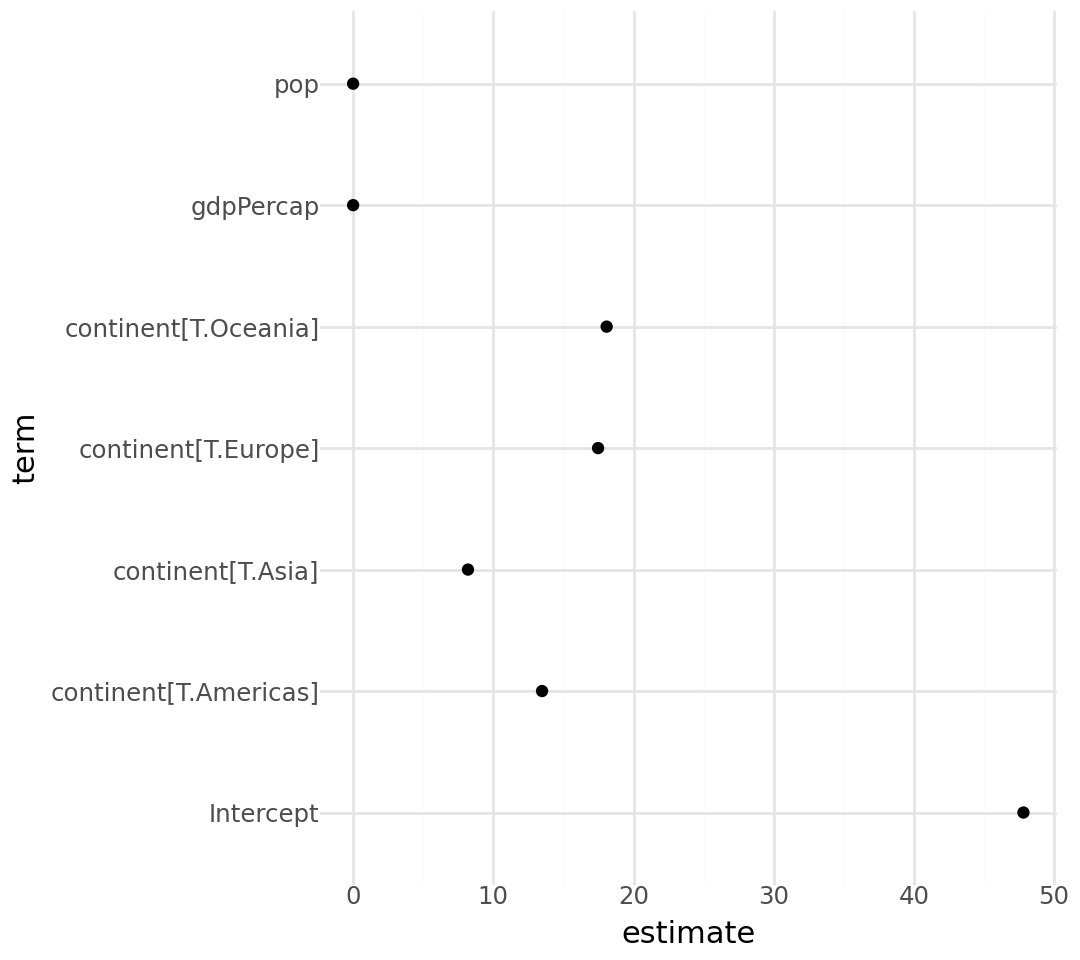

In [33]:
p = ggplot(out_comp, aes(x='term', y='estimate'))
p + geom_point() + coord_flip()

## Fig. 6.6

NOTE: The term expressions of regression results are different from R functions, but I defined the `prefix_strip()` function in Python (this function remove not only the prefix). This function works only for pandas.Series object. You can import this function by `from pysocviz.utils import prefix_strip`. The actual code is like this:

```python
def prefix_strip(series):
    return series.str.replace(r"^.+?\[T\.(.+?)\]$", r"\1", regex=True)
```

In [34]:
out_conf = tidy_ols(out, conf_int=True)
out_conf = out_conf.loc[lambda d: ~d['term'].isin(['Intercept'])]
out_conf = out_conf.assign(nicelabs=lambda d: prefix_strip(d['term']))

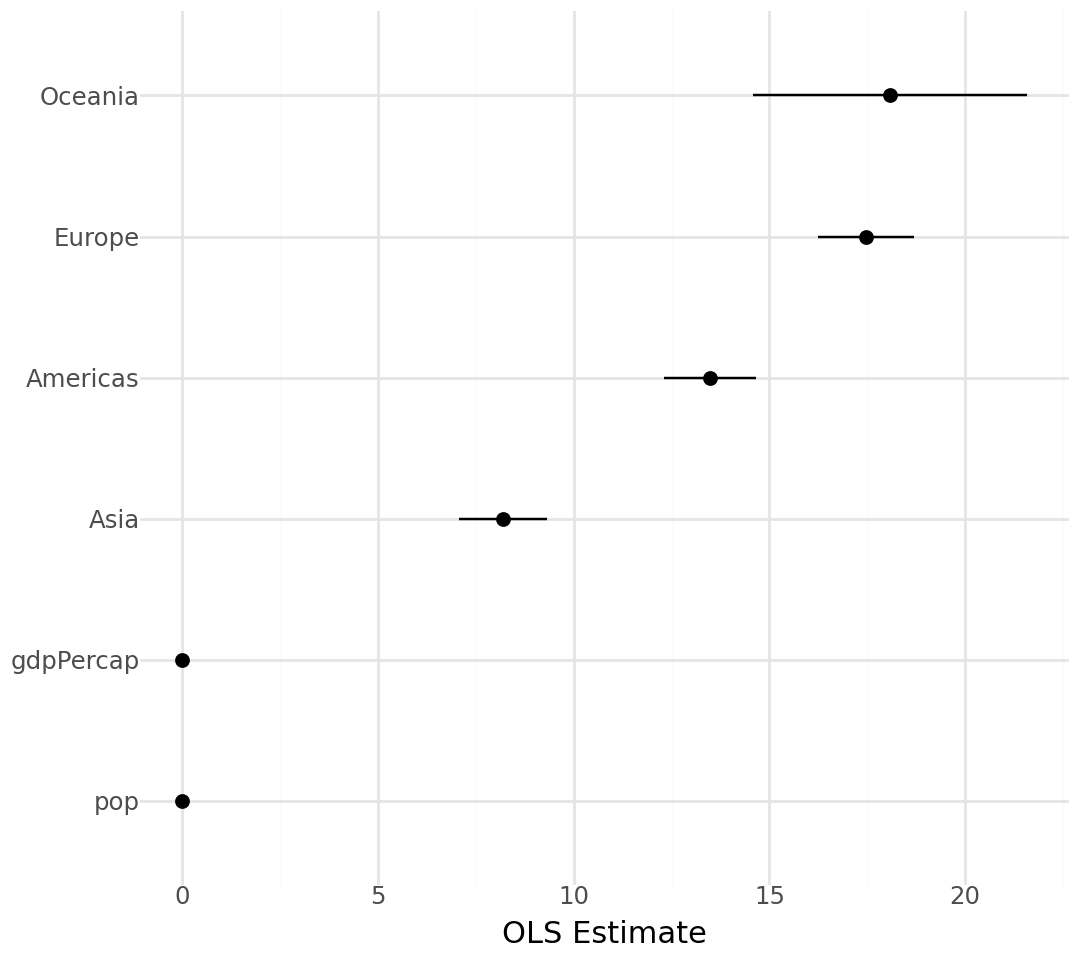

In [35]:
p = ggplot(
      out_conf,
      aes(
          x='reorder(nicelabs, estimate)',
          y='estimate',
          ymin='conf_low',
          ymax='conf_high'
      )
)
p + geom_pointrange() + coord_flip() + labs(x="", y="OLS Estimate")

## Fig. 6.7

NOTE: the definition of `_sigma` is ambigous. In the following code, I suppose it is DFFITS statistics.

In [36]:
out_aug = pd.concat([
  gapminder.assign(
    _fitted=out.fittedvalues,
    # _se_fit=None,  # not available for linear regression models
    _resid=out.resid
  ),
  out.get_influence().summary_frame().rename(
    columns={
      'hat_diag': '_hat',
      'cooks_d': '_cooksd',
      'dffits': '_sigma', # TODO: Really?
      'standard_resid': '_std_resid' 
      }
    )[['_hat', '_cooksd', '_sigma', '_std_resid']]
  ],
  axis=1
)

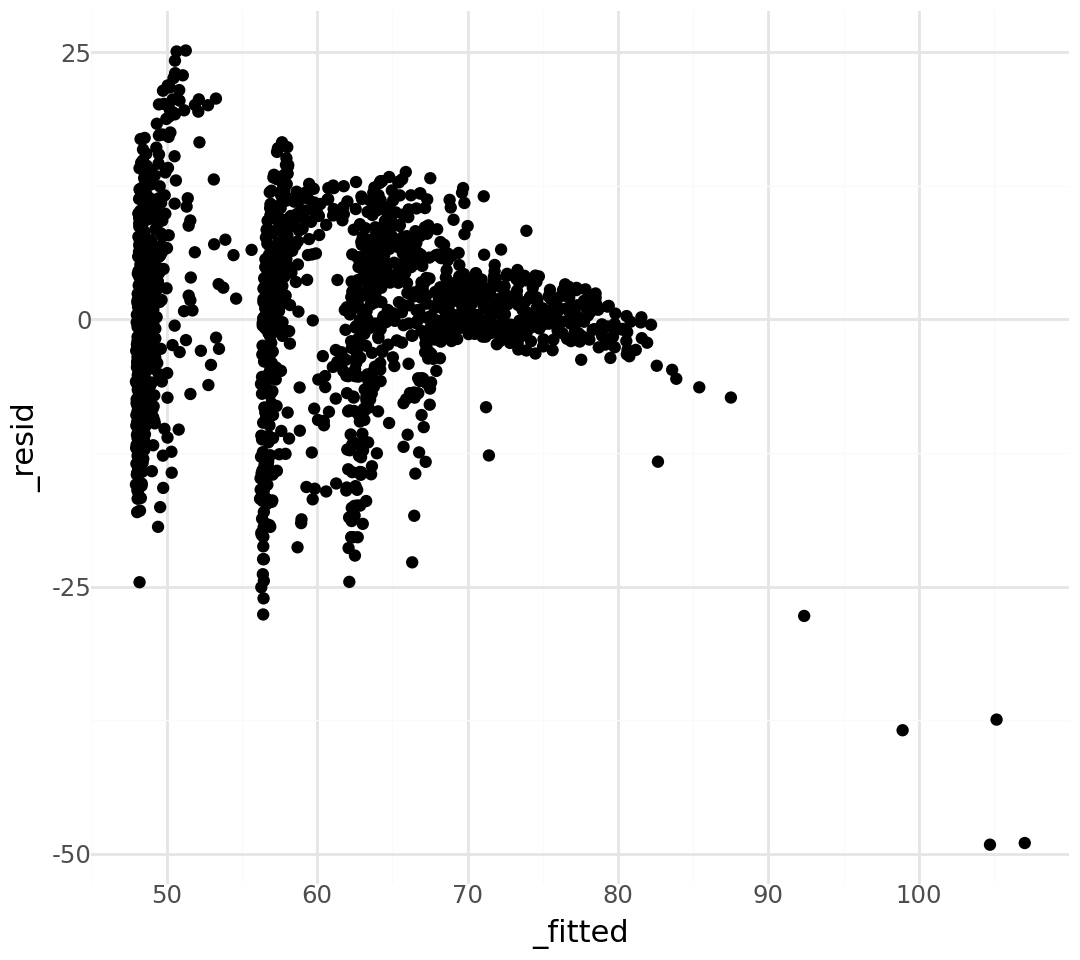

In [37]:
p = ggplot(out_aug, aes(x='_fitted', y='_resid'))
p + geom_point()

## Fig. 6.8

NOTE 1: The result data is **not equal to** the one in the original book. Since the aim of this material is to teach the method of data visualization, I saved time to search the ambigous document of statsmodels. So, please **DON'T trust** the regression and data converting part in the following code!

NOTE 2: If you want to do the survival analysis in Python, you can choose to use [lifelines](https://lifelines.readthedocs.io/en/latest/index.html) pacakge instead of statsmodels.

NOTE 3: In the original code, `geom_line()` is used. In general, however, Kaplan-Meyer plot is a step function. Moreover, `geom_line` is used repeatedly in this matarieal. So I decieded to show a usecase of `geom_step()` function.

In [38]:
out_surv = phreg('time ~ age + sex', data=lung, status=lung['status']).fit()
out_tidy = pd.DataFrame(
    {i: x for i, x in enumerate(out_surv.baseline_cumulative_hazard[0])}
).rename(
    columns={0:'time', 1: 'y1', 2: 'estimate'}
).assign(conf_low=lambda d: d['estimate'] -.3,
         conf_high=lambda d: d['estimate'] + .2
        ) # DON'T do like this!

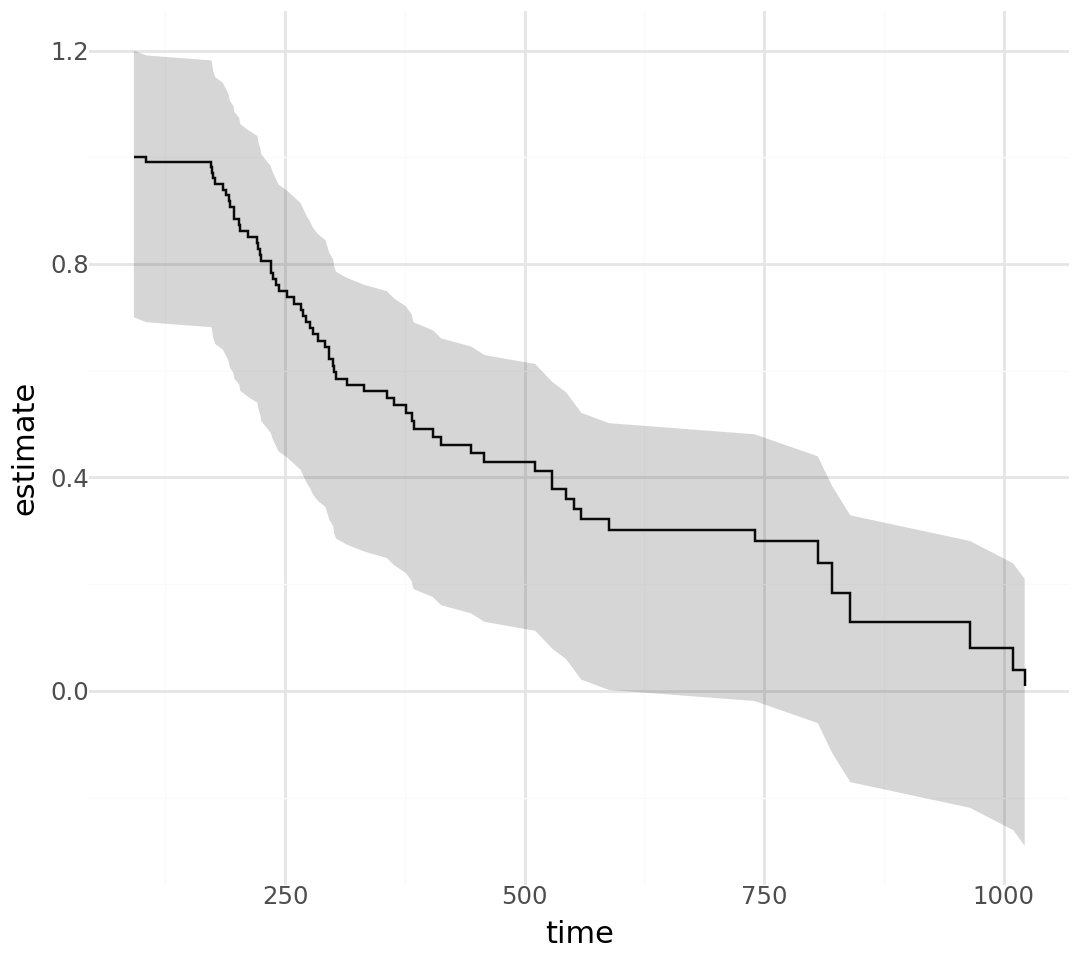

In [39]:
p = ggplot(out_tidy, aes(x='time', y='estimate'))
p + geom_step() + geom_ribbon(aes(ymin='conf_low', ymax='conf_high'), alpha=.2)

## Fig. 6.9

NOTE1: `pandas.DataFrame` naturally support nesting of data frames like `tibble` in R. nested data frame is structured by multiple index, so you can unnest the inner data frames by `.reset_index()`. In addition you can contain an array-like object in `pandas.Series` element. You can expand such columns by `.explode()` method.

NOTE2: I used `tidy_ols()` which have been already defined.

NOTE3: In the original code, the results on Oceania are dropped after running of the regession. But I dropped these observations before the regression process because of saving resource and prevent cumbersome warnings.

In [40]:
out_tidy = gapminder.loc[
    lambda d: ~d['continent'].isin(['Oceania'])
].groupby(['continent', 'year']).apply(
  lambda x: tidy_ols(ols('lifeExp ~ np.log(gdpPercap)', data=x).fit())
).reset_index().drop(columns=['level_2']
).loc[
  lambda d: ~d['term'].isin(['Intercept'])
]

/tmp/ipykernel_17712/2788711220.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


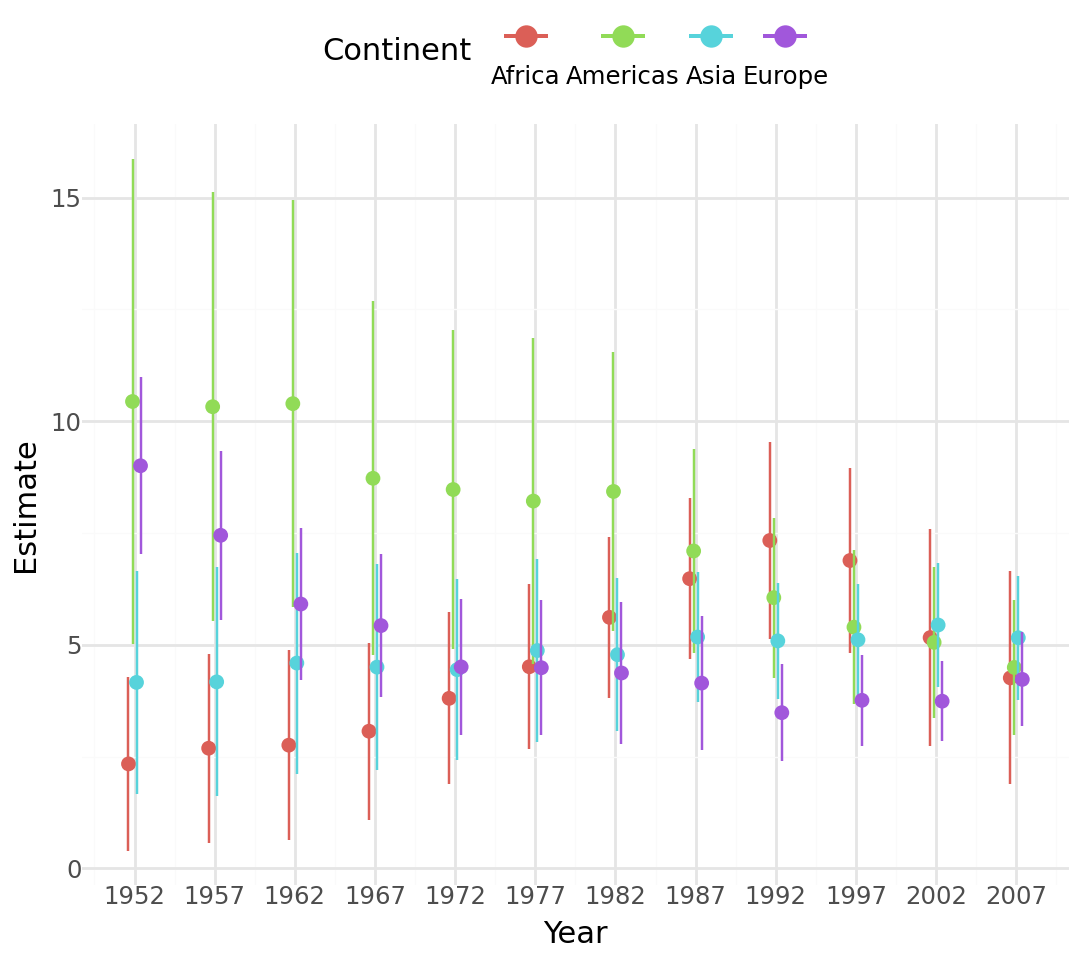

In [41]:
p = ggplot(
  out_tidy,
  aes(
    x='year',
    y='estimate',
    ymin='estimate - 2 * std_error',
    ymax='estimate + 2 * std_error',
    group='continent',
    color='continent'
  )
)
p + geom_pointrange(
  position=position_dodge(width=1)
) + scale_x_continuous(
  breaks=gapminder['year'].unique()
) + theme(legend_position='top') + labs(
  x='Year', y='Estimate', color='Continent'
)

## Fig. 6.10

NOTE 1: There are no Python packages such like **magrins** in R. In particlar, `glm` doesn't have any method which calculates its marginal effects. However, in this case, the model is equivalent to a logistic regression model, of which result is implemented in statsmodels as `LogitResults` and it has `get_margeff()` method.

NOTE 2: In this examples, I introduce a utility function `pysocviz.utils.brackets_replace` which is counterpart to `prefix_replace` function in the original. The code is like this.

```python
def brackets_replace(series, sep=': '):
    return series.str.replace(r"^(.+?)\[T\.(.+?)\]$", f"\\1{sep}\\2", regex=True)
```

In [42]:
# glm doesn't have get_megeff method...
model_bo = logit(
    'obama ~ C(polviews, Treatment(reference="Moderate")) + sex * race',
    data=gss_sm
)
out_bo = model_bo.fit()

bo_gg = pd.DataFrame(out_bo.get_margeff(at='mean').summary().tables[1].data)[1:]
bo_gg.columns = ['factor', 'AME', 'std_err', 'z', 'p', 'lower', 'upper']
for c in bo_gg.columns:
    if c != 'factor':
        bo_gg[c] = bo_gg[c].astype(float)
bo_gg = bo_gg.loc[lambda d: d['factor'].str.split(':').apply(len) == 1].assign(
    factor=lambda d: brackets_replace(d['factor'])
).assign(
    factor=lambda d: d['factor'].str.replace('^C\(.+?\)\):', '', regex=True)
)

Optimization terminated successfully.
         Current function value: 0.396313
         Iterations 8


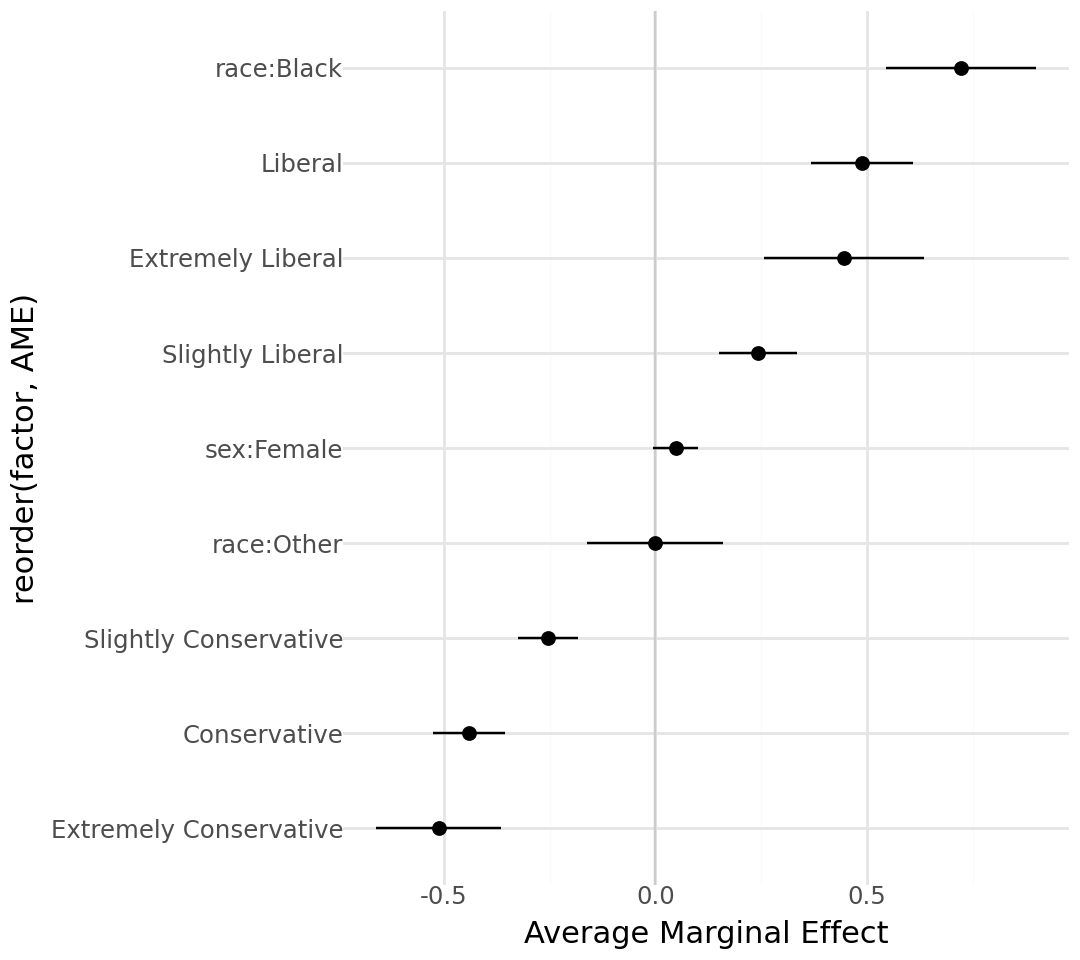

In [43]:
p = ggplot(bo_gg, aes(x='reorder(factor, AME)', y='AME', ymin='lower', ymax='upper'))
p + geom_hline(yintercept=0, color=dcolors["gray80"]) + geom_pointrange(
)  + coord_flip() + labs(x=None, y="Average Marginal Effect") 

## Fig. 6.11

NOTE: I don't familiar with **margins** package and how to calculate "conditional predicted values" in `cplot()` function. But after trying some case, I suupose that this value is the predicted probabilites (response values) against the specified single variable with fixed value, other all numerical variables with **mean**s and other all categorical variables with **mode**s in the train dataset. I defined `cplot` function, which is simple version of the original function in R. This function is assumed to calculate the marginal effect at only categorical variables. Moreover, because of the lack of consistent conversion function of [patsy](https://patsy.readthedocs.io/en/latest/) package's design matrices (`dmatrix`/`dmatrices`, not impossible, but very hard work), this function has inefficiency. You can import this function by `from pysocviz.utils import cplot`

In [44]:
def cplot(fit, formula, data, at):
    """
    plotting ommitted, only a data frame.
    """
    funs = {
        name: 'mean' if dtype in [
            'float64', 'int64'
        ] else lambda col: col.value_counts(
        ).index[0] for name, dtype in zip(data.columns, data.dtypes)
    }
    aux = pd.DataFrame(data.agg(funs)).transpose()
    fixed = data[at].unique()
    X = pd.concat([aux.assign(**{at: val}) for val in fixed])
    cpv = fit.predict(X, linear=False)
    # statsmodels cannot return predictive intervals.
    # So I calculate that approximately by the delta method.
    # See this in detail:
    # https://stackoverflow.com/questions/47414842/confidence-interval-of-probability-prediction-from-logistic-regression-statsmode
    #
    # ugly trick!
    dmx = patsy.dmatrix(
        formula.split('~')[1],
        pd.concat([data] + [aux.assign(**{at: x}) for x in fixed])
    )[-fixed.shape[0]:, :]
    cov = np.array(fit.cov_params())
    gradient = (np.array(cpv) * (1 - np.array(cpv)) * dmx.T).T
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    c = 1.96
    upper = np.maximum(0, np.minimum(1, cpv + std_errors * c))
    lower = np.maximum(0, np.minimum(1, cpv - std_errors * c))
    return pd.DataFrame({'xvals': fixed, 'yvals': cpv, 'upper': upper, 'lower': lower})

In [45]:
pv_cp = cplot(out_bo, model_bo.formula, gss_sm, at='sex')

/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:530: FutureWarning: linear keyword is deprecated, use which="linear"


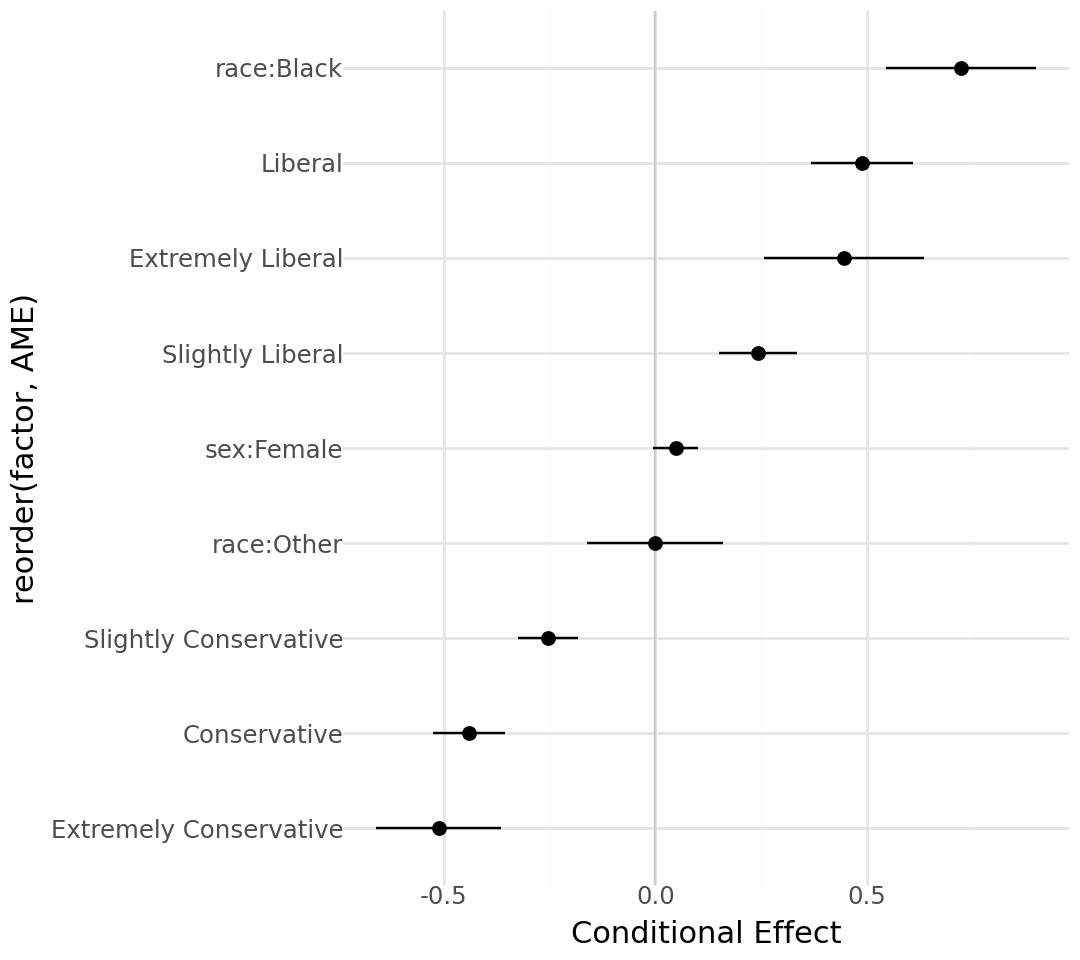

In [46]:
ggplot(
    pv_cp, 
    aes(x='reorder(xvals, yvals)', y='yvals', ymin='lower', ymax='upper')
)

p + geom_hline(
    yintercept=0, color=dcolors['gray80']
) + geom_pointrange() + coord_flip(
) + labs(x=None, y="Conditional Effect") 

## Fig. 6.12

NOTE 1: These packages are also inavailable in Python package. But I'm tired of emulating such datasets. So in this example, I didn't make a correct dataset.

NOTE 2: **mizani** currently doesn't support label wrapping. So I defined the function `wrap_format` on my own. You can import it by `from pysocviz.p9extra import wrap_format`.

In [47]:
out_grp = gss_lon.loc[
    lambda d: d['year'].isin(np.floor(np.linspace(1976, 2016, 4)))
].merge(gss_lon.groupby('year')['age'].sum().reset_index(), on='year').assign(
    prop=lambda d: d['age_x'] / d['age_y'] * 1000
).groupby(['year', 'race', 'degree'])[['prop']].agg({'prop': ['mean', 'sem']}).reset_index()
out_grp = out_grp.assign(year=lambda d: d['year'].astype(int).astype(str))
out_grp.columns = ['year', 'race', 'degree', 'prop', 'prop_se']

/tmp/ipykernel_17712/3974748318.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_col : Removed 1 rows containing missing values.
/home/ks/.pyenv/versions/3.9.10/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 1 rows containing missing values.


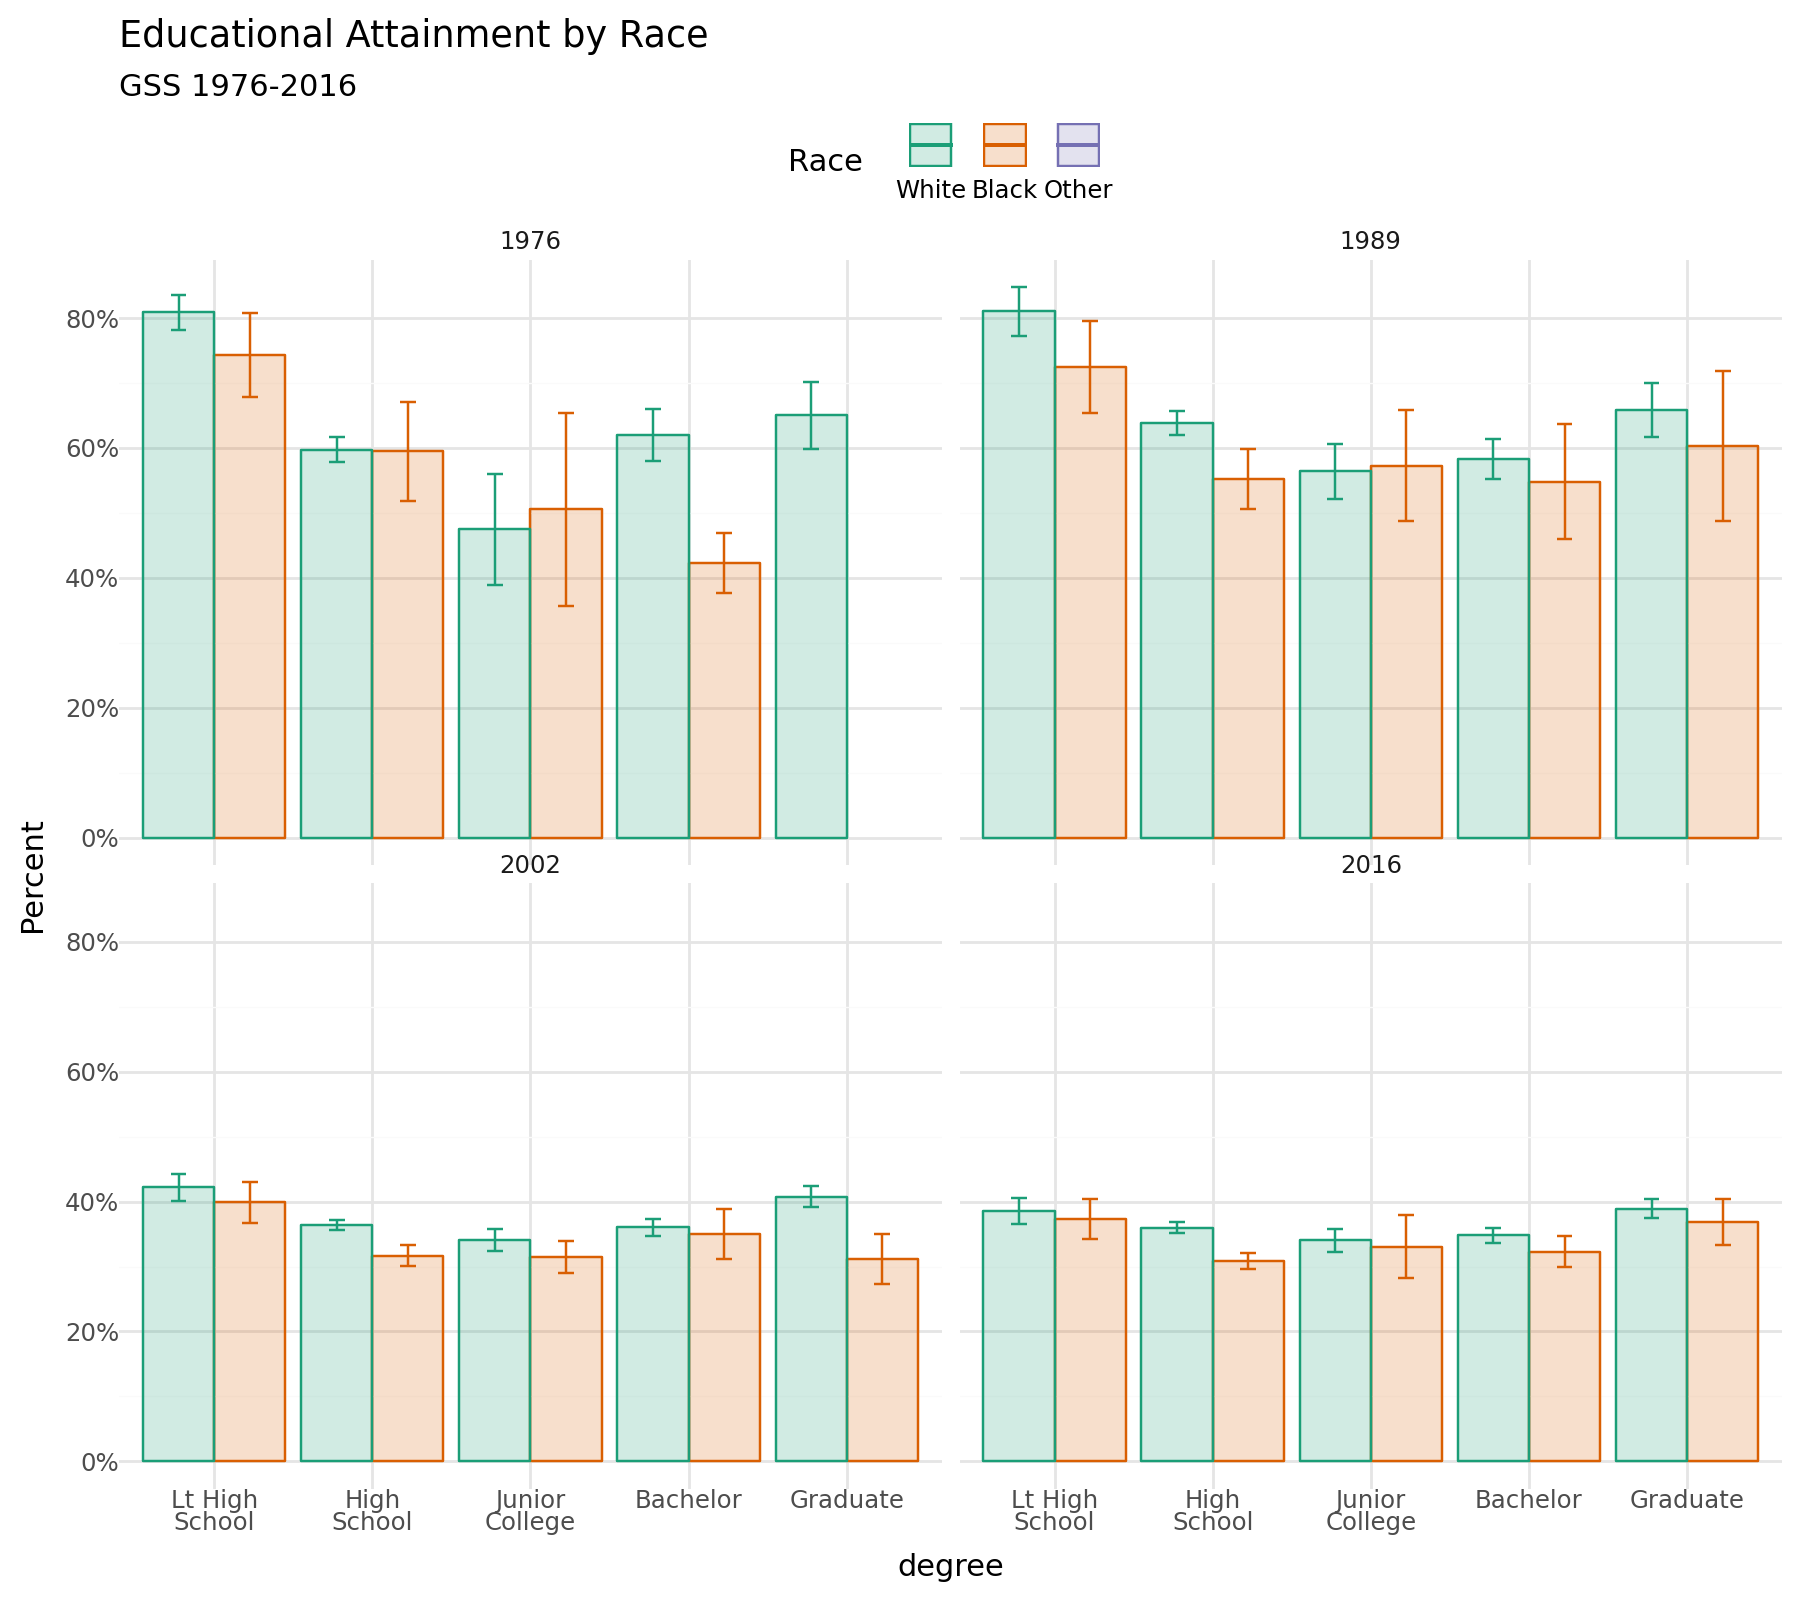

In [48]:
p = ggplot(
    out_grp.loc[lambda d: ~d['race'].isin(['Other'])],
    aes(x='degree', y='prop',
        ymin='prop - 2 * prop_se', ymax='prop + 2 * prop_se',
        fill='race', color='race', group='race'),
)
dodge = position_dodge(width=0.9)
p + geom_col(position=dodge, alpha=0.2
) + geom_errorbar(position=dodge, width=0.2
) + scale_x_discrete(labels=wrap_format(10),
) + scale_y_continuous(labels=label_percent()
) + scale_color_brewer('qual', 'Dark2'
) + scale_fill_brewer('qual', 'Dark2'
) + labs(
    title="Educational Attainment by Race",
    subtitle="GSS 1976-2016",
    fill="Race",
    color="Race",
    x=None,
    y="Percent"
) + facet_wrap('~year', ncol=2
) + theme(legend_position='top', figure_size=(9, 8)) 

## Fig. 6.13

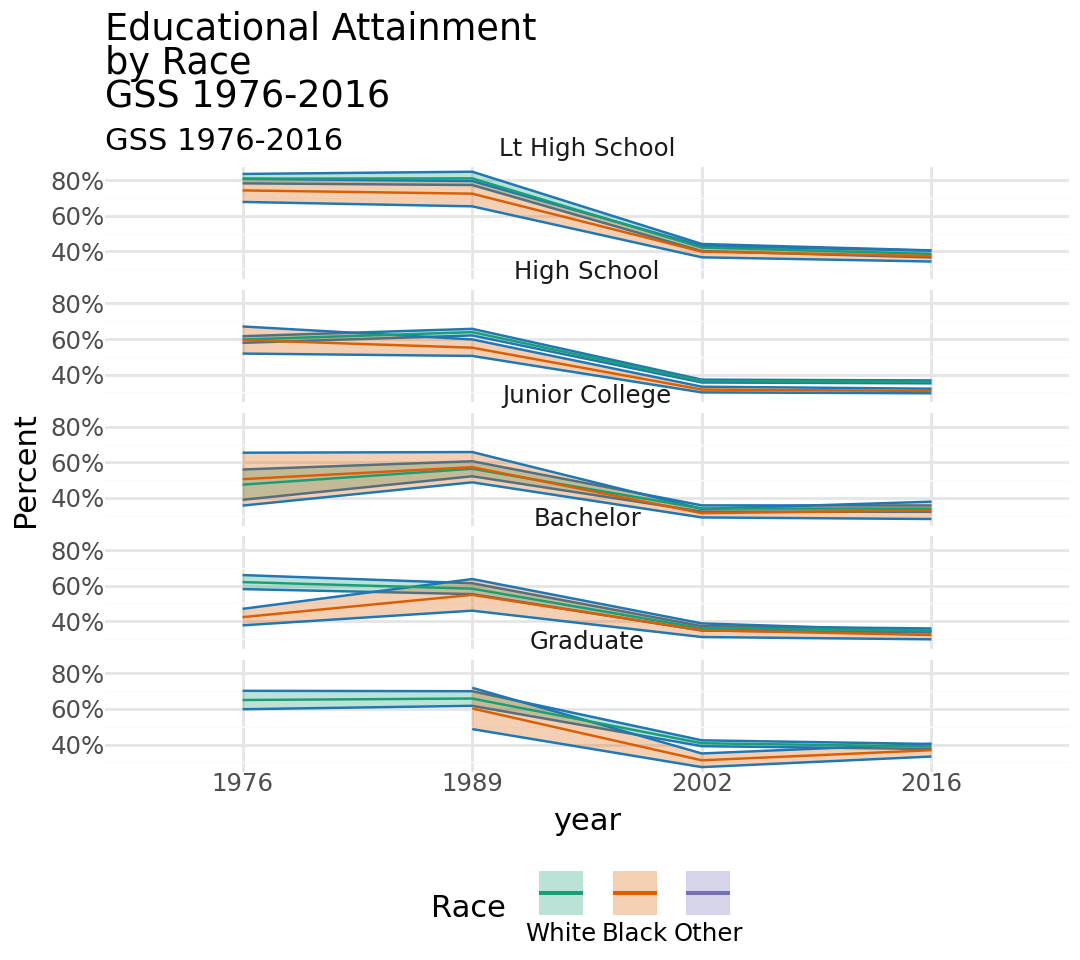

In [49]:
p = ggplot(
    out_grp.loc[lambda d: ~d['race'].isin(['Other'])],
    aes(x='year', y='prop',
        ymin='prop - 2 * prop_se', ymax='prop + 2*prop_se',
        fill='race', color='race', group='race')
)

p + geom_ribbon(alpha=0.3, color=None) + geom_line(
) + facet_wrap('~ degree', ncol=1
) + scale_y_continuous(labels = label_percent()
) + scale_color_brewer('qual', 'Dark2'
) + scale_fill_brewer('qual', 'Dark2'
) + labs(
    title='\n'.join([
        'Educational Attainment\nby Race',
        'GSS 1976-2016'
    ]),
    subtitle="GSS 1976-2016",
    fill="Race",
    color="Race",
    x=None,
    y="Percent"
) + theme(
    legend_position='bottom',
    legend_direction='horizontal'
)

## Fig. 6.14

NOTE 1: Instead of **coefplots** packages, I defined an alike function. But it's not a complete substitution of `coefplot()` function, it's options are very limited. This function depends on `tidy_ols()`. You can also import this function by `from pysocviz.utils import coefplot`.

NOTE 2: The output of this function is almost same as the simple code at Fig. 6.6. Hence maybe such function is not so useful in genrenal.

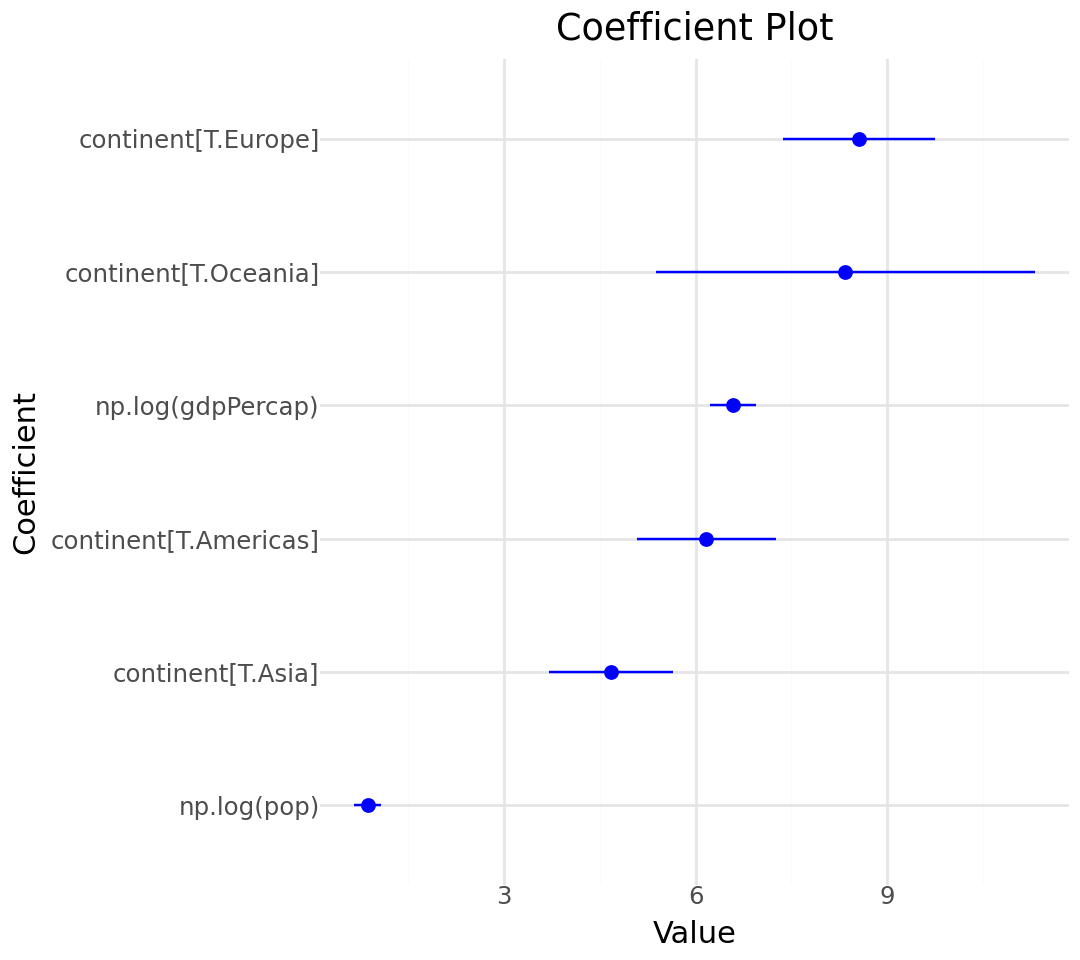

In [50]:
out = ols(
    'lifeExp ~ np.log(gdpPercap) + np.log(pop) + continent',
    data = gapminder
).fit()

coefplot(out, intercept=False, sort='magnitude')

## Fig. 6.15

NOTE 1: This figure is somehow missing from the online version.

NOTE 2: Of course, **GGallay** package is not availabel for Python. It is difficult to create such plots by plotnine. There are some compromise plans: (1) using `pandas.plotting.scatter_matrix`, (2) using `seaborn.pairplot`. Both of the methods can't display both numeric and categorical variables simultaneously.

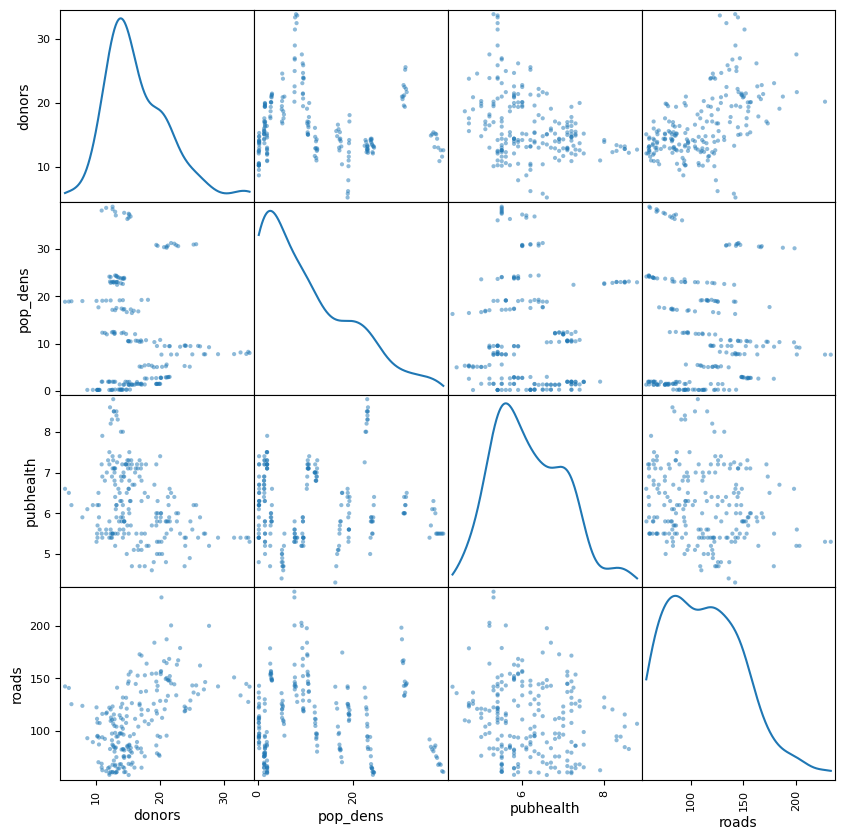

In [51]:
organdata_sm = organdata[['donors', 'pop_dens', 'pubhealth', 'roads', 'consent_law']]

_ = pd.plotting.scatter_matrix(organdata_sm, diagonal='kde', figsize=(10, 10))

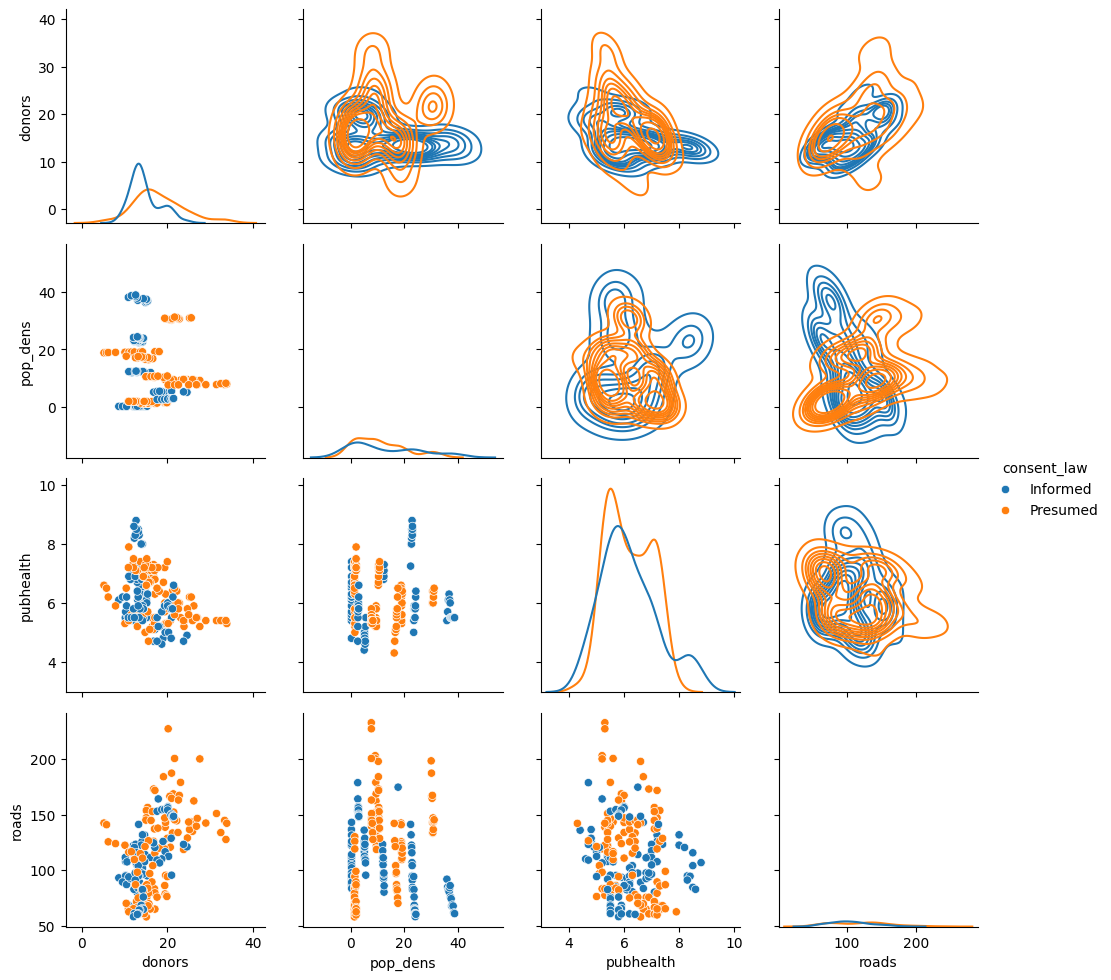

In [52]:
g = sns.PairGrid(organdata_sm, hue='consent_law')
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
_ = g.add_legend()